In [5]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [106]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    print("Multi_choice", multi_choice_columns)
    data = data.drop(multi_choice_columns, axis=1)
    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    print("Category Columns:",cat_columns)
    #data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 200 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[(~(data["ConvertedComp"]<100) &  (data.MainBranch == "I am a developer by profession"))]
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with mean
    nas = data.isna().sum()
    nas = nas[nas > 0]
    
    avg_prf_comp_by_country = data[data.MainBranch == "I am a developer by profession"].groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    data["ConvertedComp_index"] = data.apply(target_transformer, axis=1)

    #LABEL :"ConvertedComp"
    return data, multi_choice_columns, cat_columns

In [107]:
data, multi_choice_columns, cat_columns = initial_data_preparation()

64461 Rows.
Multi_choice ['DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'Ethnicity', 'Gender', 'JobFactors', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWPurchaseResearch', 'NEWSOSites', 'NEWStuck', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'Sexuality', 'WebframeDesireNextYear', 'WebframeWorkedWith']
Category Columns: ['Country', 'JobSat', 'JobSeek', 'Employment', 'MainBranch', 'Hobbyist', 'EdLevel', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurpleLink', 'OpSys', 'OrgSize', 'PurchaseWhat', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WelcomeChange']
27366 Rows.


In [108]:
data.head()

,MainBranch,Hobbyist,Age,Age1stCode,ConvertedComp,Country,EdLevel,Employment,JobSat,JobSeek,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurpleLink,OpSys,OrgSize,PurchaseWhat,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_IBM DB2,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_Couchbase,DatabaseWorkedWith_Couchbase,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_Redis,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_Cassandra,DevType_Scientist,"DevType_Developer, back-end","DevType_Developer, desktop or enterprise applications","DevType_Developer, front-end","DevType_Developer, full-stack","DevType_Developer, game or graphics","DevType_Developer, mobile",DevType_Academic researcher,DevType_Database administrator,DevType_Designer,"DevType_Developer, QA or test","DevType_Engineer, data",DevType_Data or business analyst,DevType_Product manager,DevType_Data scientist or machine learning specialist,"DevType_Developer, embedded applications or devices",DevType_DevOps specialist,DevType_System administrator,DevType_Senior executive/VP,"DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Educator,DevType_Marketing or sales professional,Ethnicity_White or of European descent,Ethnicity_South Asian,Ethnicity_East Asian,Ethnicity_Biracial,Ethnicity_Multiracial,Ethnicity_Black or of African descent,Ethnicity_Southeast Asian,Ethnicity_Middle Eastern,"Ethnicity_Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Ethnicity_Hispanic or Latino/a/x,Gender_Man,"Gender_Non-binary, genderqueer, or gender non-conforming",Gender_Woman,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_How widely used or impactful my work output would be,JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Diversity of the company or organization,JobFactors_Specific department or team I’d be working on,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Family friendliness,JobFactors_Flex time or a flexible schedule,LanguageDesireNextYear_C#,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_C,LanguageDesireNextYear_C++,LanguageDesireNextYear_Dart,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_Java,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Objective-C,LanguageDesireNextYear_Perl,LanguageDesireNextYear_Swift,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Go,LanguageDesireNextYear_Rust,LanguageDesireNextYear_Julia,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Scala,LanguageDesireNextYear_Assembly,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,Lan

## TODO
- How many technologies he/she would like to learn? (DatabaseDesireNextYear, LanguageDesireNextYear) - Erdem **DONE**
- How many technologies was used in the past? (DatabaseWorkedWith, LanguageWorkedWith) - Erdem **DONE**
- Interaction between Job Satisfaction & Job Seeking columns and their impact on  compansation - Berk
- New Job Hunt:Better Comp. & Job Seeking. - Berk
- Target Encoding - Country:Done Target Transformation, Tech, Currency  - **Inprogress**

### Professional Developer Compantsations by Country

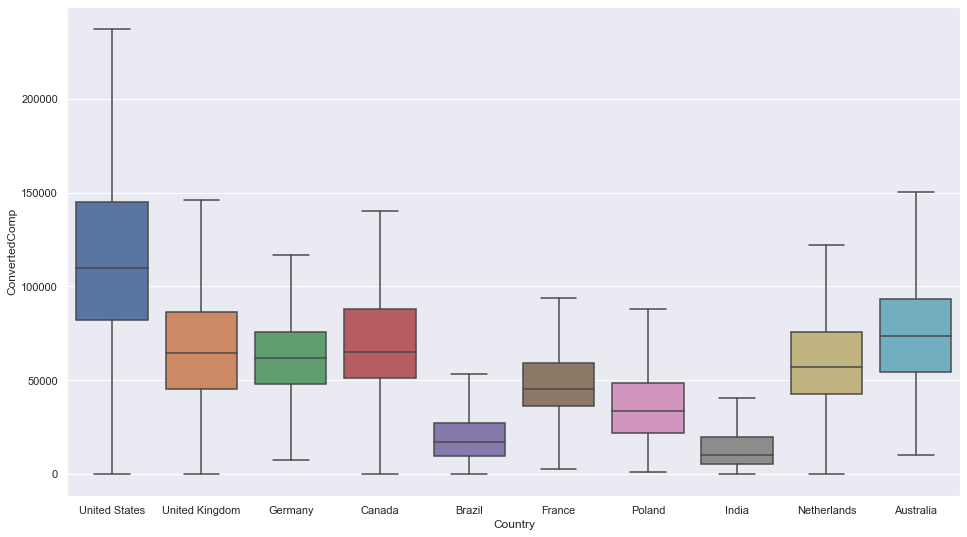

In [122]:
top_countries = data.Country.value_counts().head(10).index.tolist()
top_countries = data[data.Country.isin(top_countries) 
                     & (data.MainBranch == "I am a developer by profession")
                   &  (data.ConvertedComp <= 300000)]
ax = sns.boxplot(x="Country", y="ConvertedComp", data=top_countries,
                 showfliers = False)

### Professional Developer Compantsations by YearsCodePro

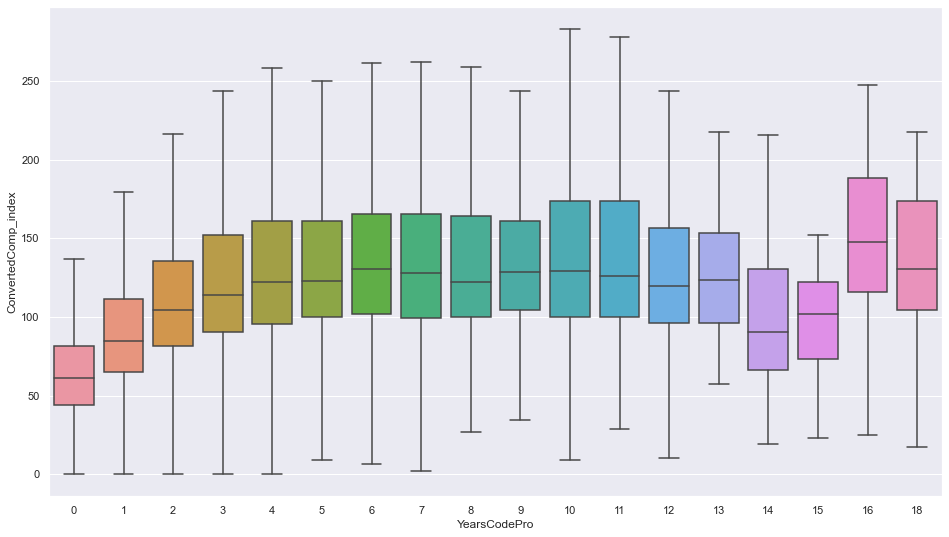

In [128]:
data_ = data[(data.MainBranch == "I am a developer by profession")
            &(data.ConvertedComp <= 300000)]
data_ = data_.dropna(subset=["YearsCodePro"])
data_.YearsCodePro = data_.YearsCodePro.apply(lambda x: int(x/3))
ax = sns.boxplot(x="YearsCodePro", y="ConvertedComp_index", data=data_,
                 showfliers = False)

### Professional Developer Compantsations by Education Level

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          13368
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        6980
Some college/university study without earning a degree                                 3195
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     1157
Associate degree (A.A., A.S., etc.)                                                     963
Other doctoral degree (Ph.D., Ed.D., etc.)                                              718
Professional degree (JD, MD, etc.)                                                      324
I never completed any formal education                                                  114
Primary/elementary school                                                               107
Name: EdLevel, dtype: int64


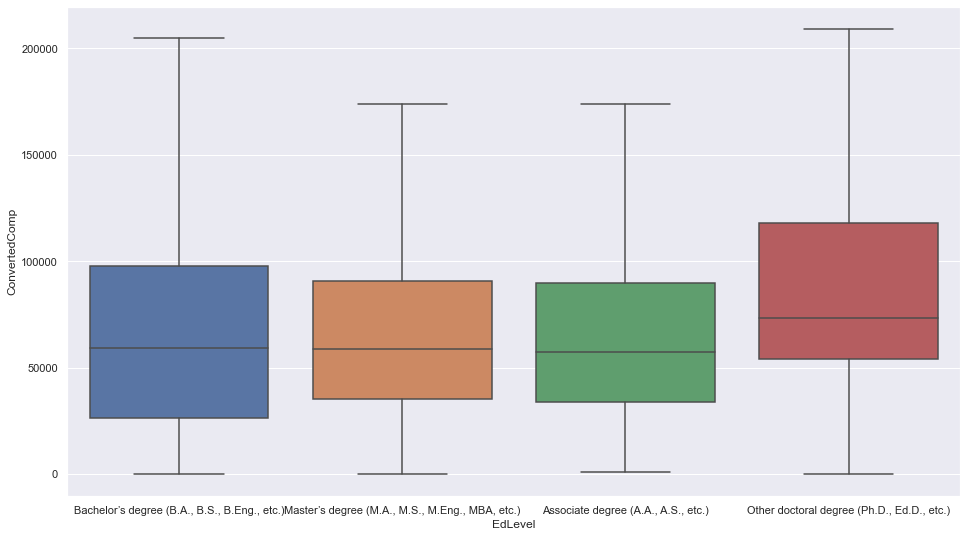

In [111]:
print(data.EdLevel.value_counts())

degrees = ['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
            'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
            'Other doctoral degree (Ph.D., Ed.D., etc.)',
           "Associate degree (A.A., A.S., etc.)"
          ]

data_ =  data[data.EdLevel.isin(degrees) 
              & (data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

ax = sns.boxplot(x="EdLevel", y="ConvertedComp", data=data_,
                 showfliers = False)

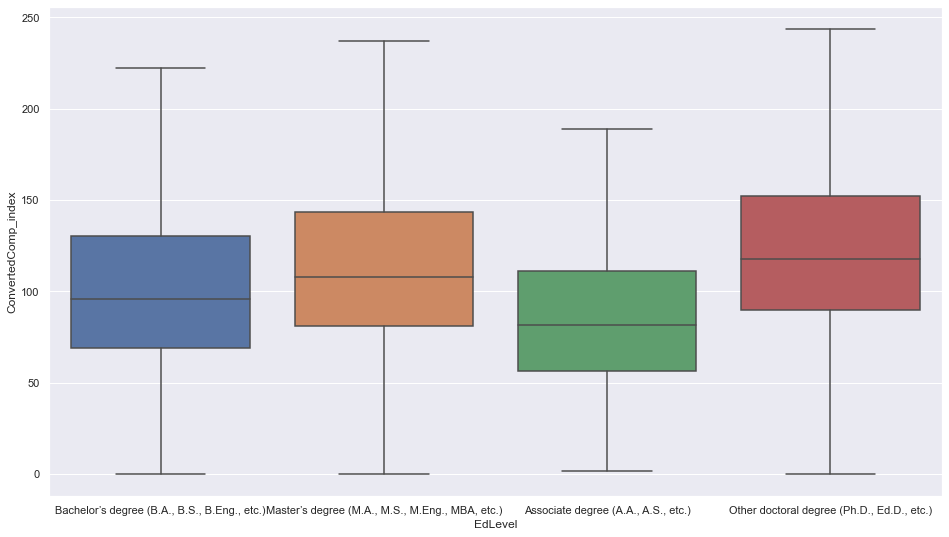

In [112]:
ax = sns.boxplot(x="EdLevel", y="ConvertedComp_index", data=data_,
                 showfliers = False)

### Professional Developer Compantsations by Country

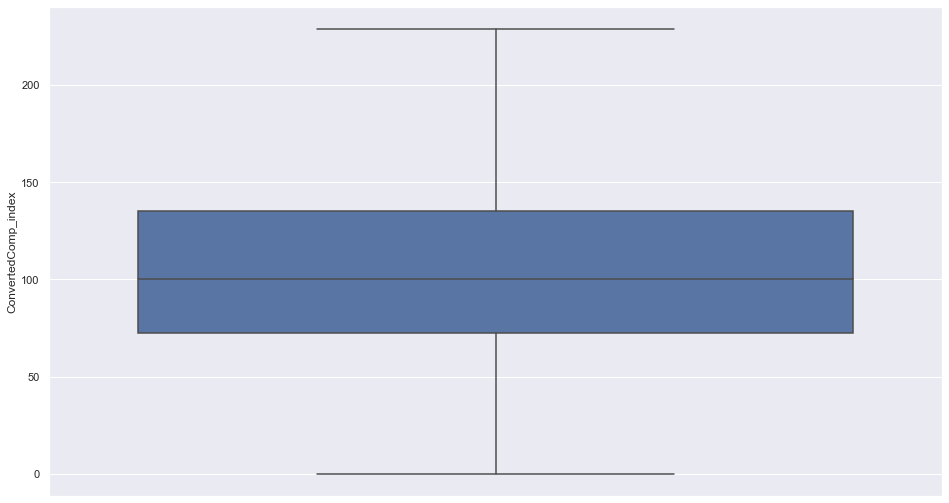

In [113]:
ax = sns.boxplot( y="ConvertedComp_index", data=data_,
                 showfliers = False)

### Job Satisfaction & Job Search

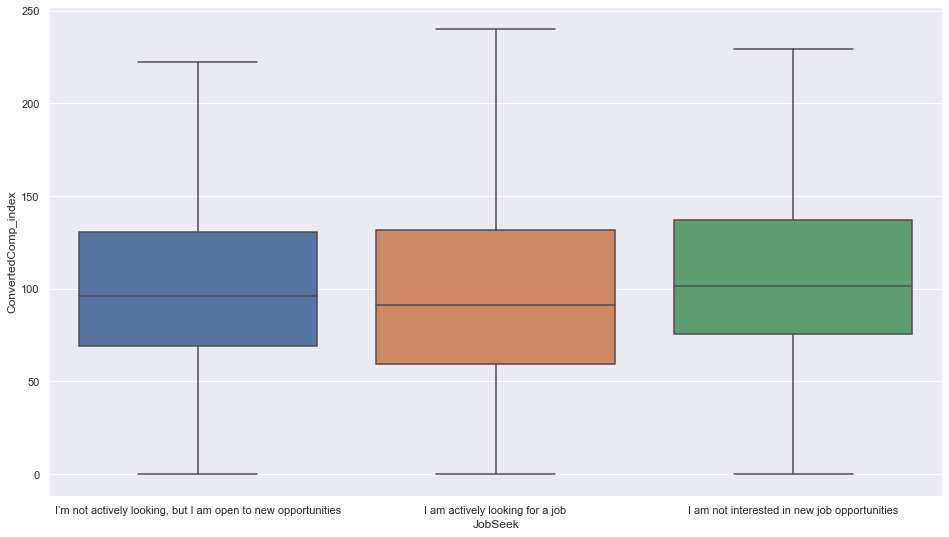

In [120]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

ax = sns.boxplot(x="JobSeek", y="ConvertedComp_index", data=data_,
                 showfliers = False)

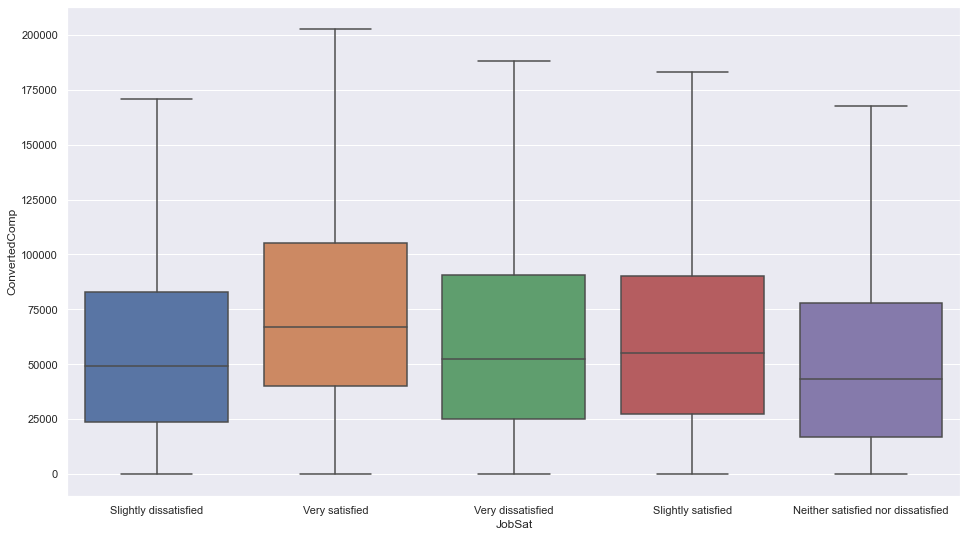

In [117]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

ax = sns.boxplot(x="JobSat", y="ConvertedComp", data=data_,
                 showfliers = False)

### By technologies WorkedWith

In [144]:
def calculate_high_and_low_leverage_tech(data):
    technologies = [feat for feat in data.columns if "WorkedWith" in feat]
    us_data = data[data["Country_for_target_transformation"] =="United States"]
    tech_leverages = {}
    for tech in technologies:
        tech_mean = us_data.groupby(tech).ConvertedComp.median()
        if len(tech_mean) != 2: continue
        tech_leverage = (tech_mean.loc[1] / tech_mean.loc[0]) -1
        tech_leverages[tech] = tech_leverage
    tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

    high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
    low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
    return high_leverage_technologies, low_leverage_technologies
high_leverage_technologies, low_leverage_technologies = calculate_high_and_low_leverage_tech(data)

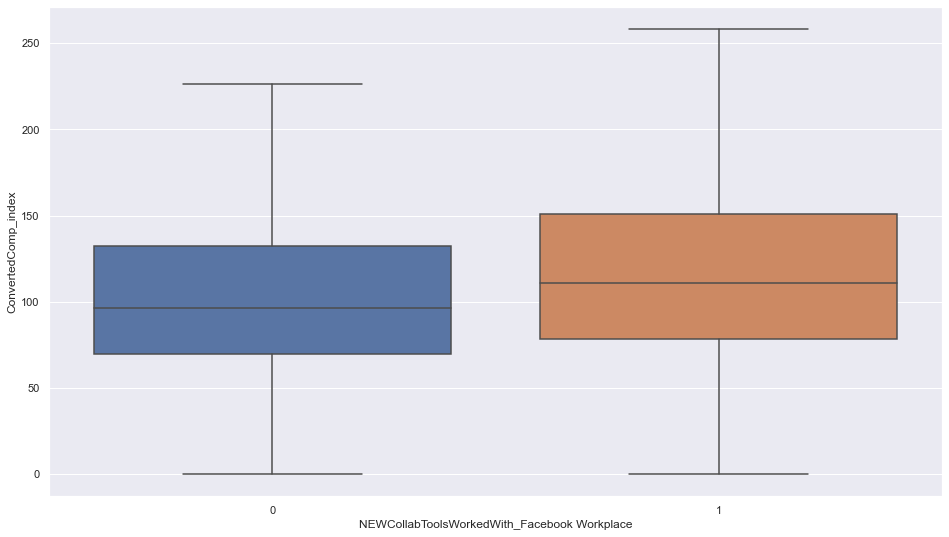

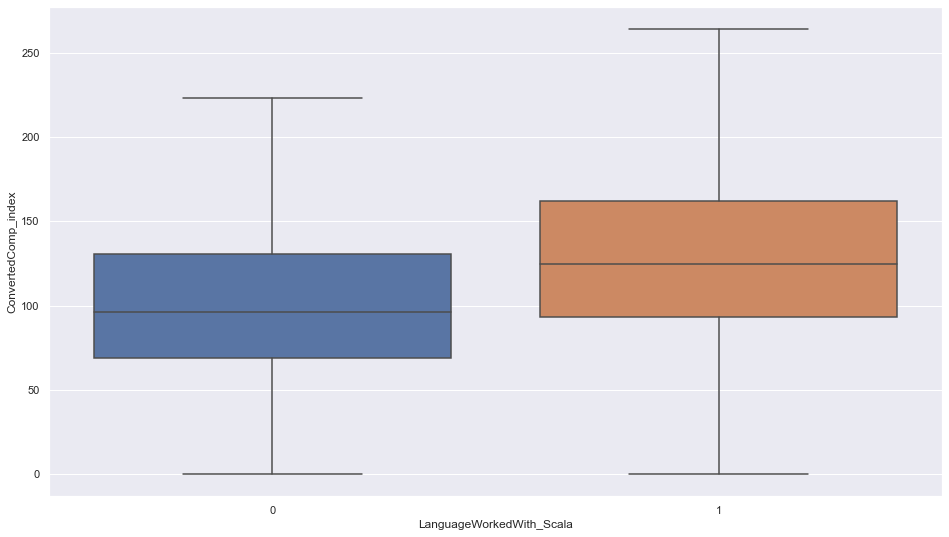

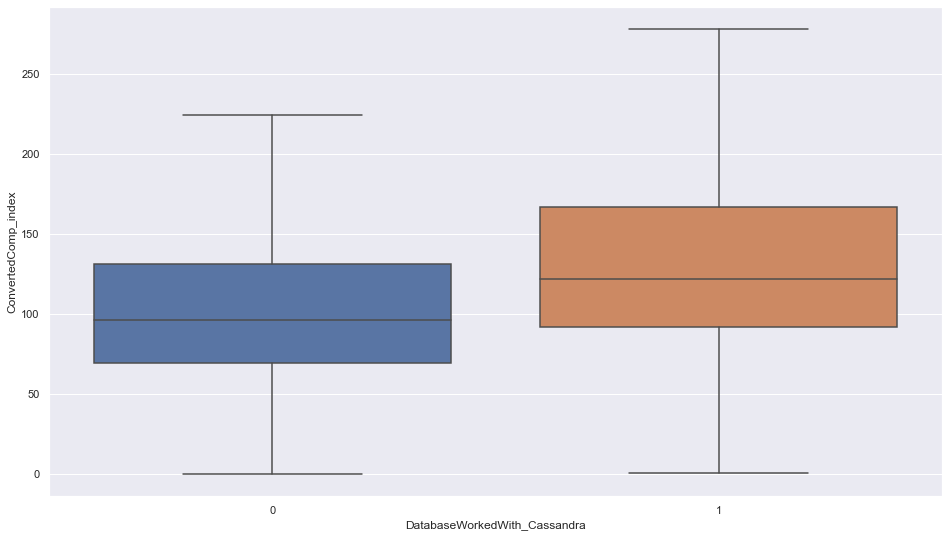

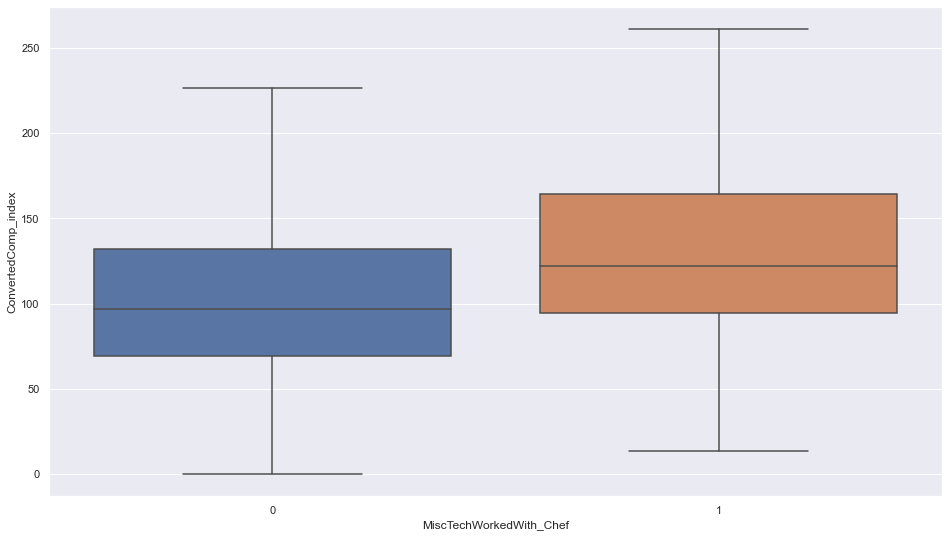

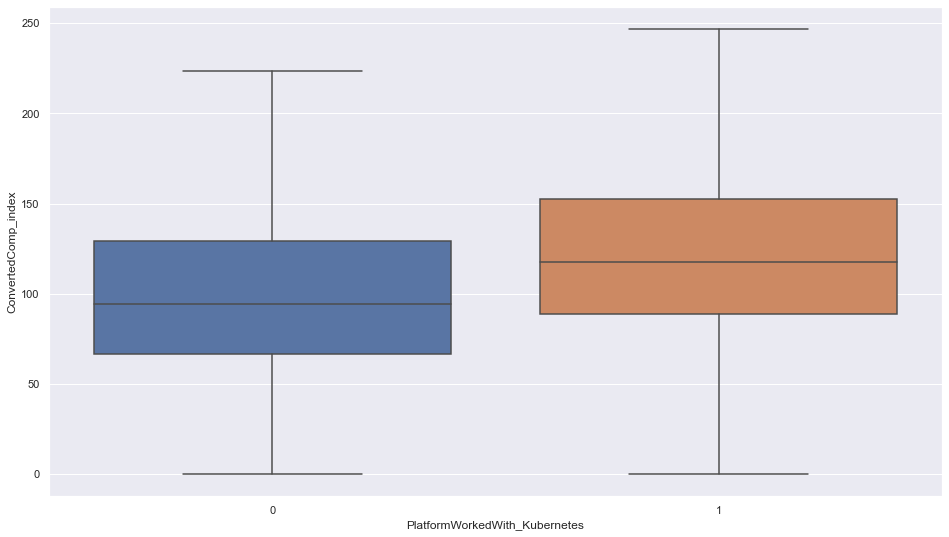

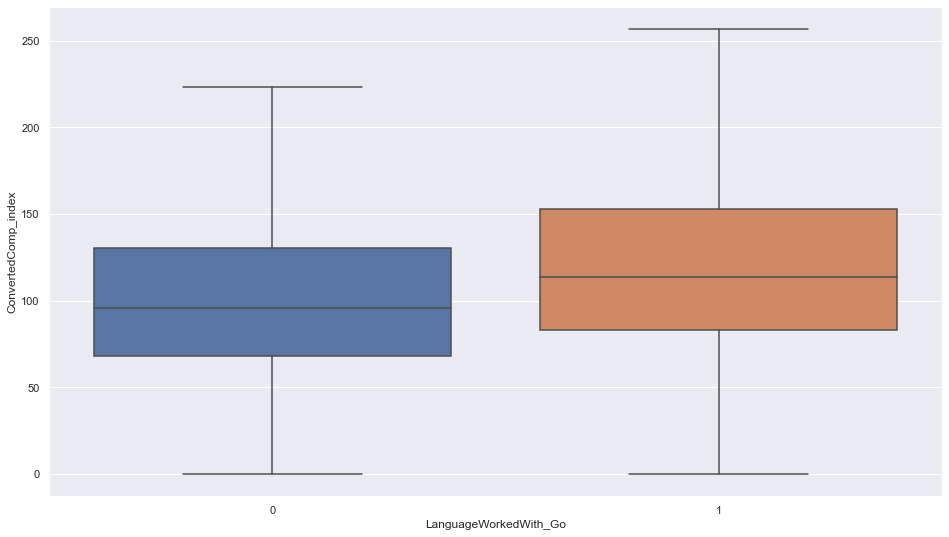

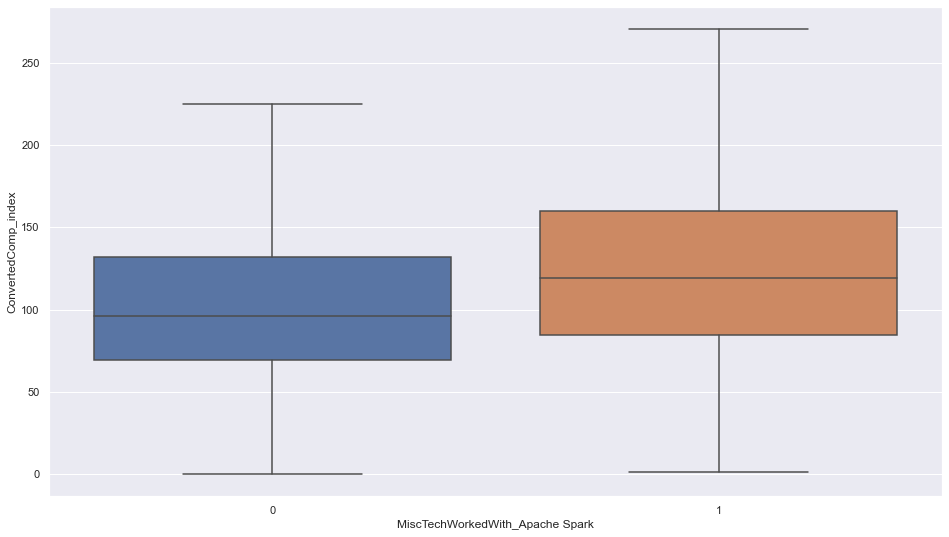

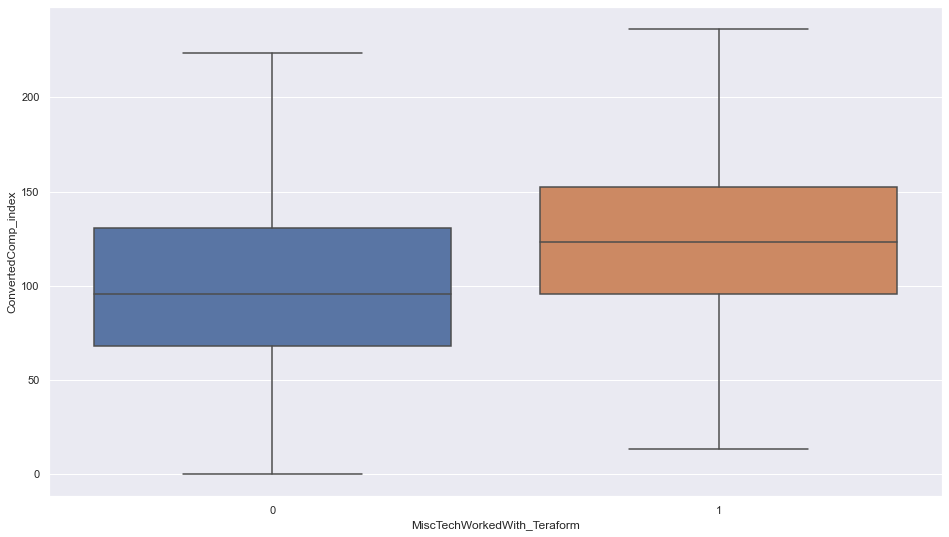

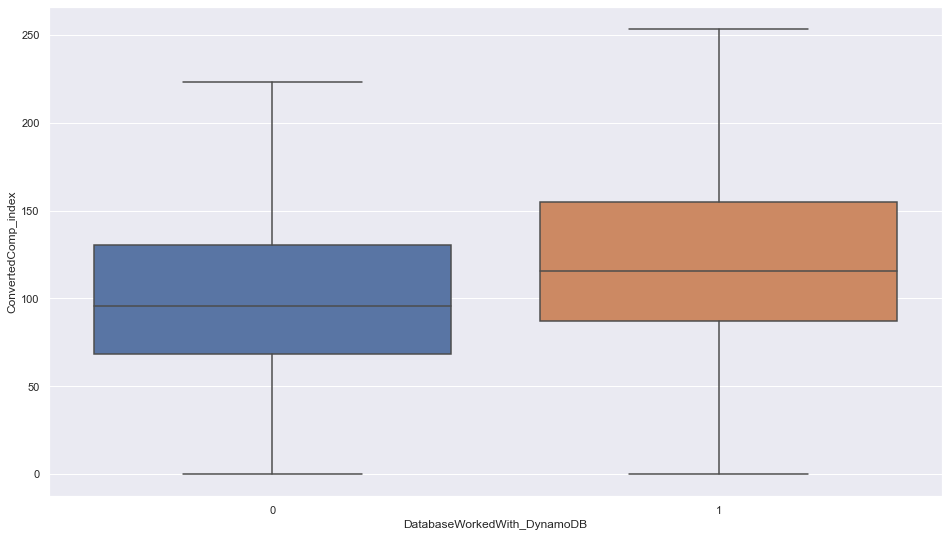

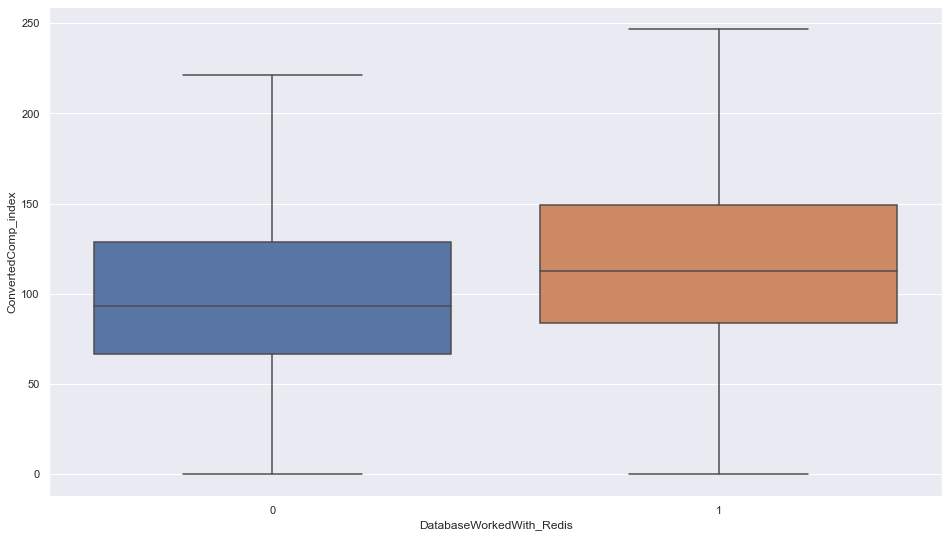

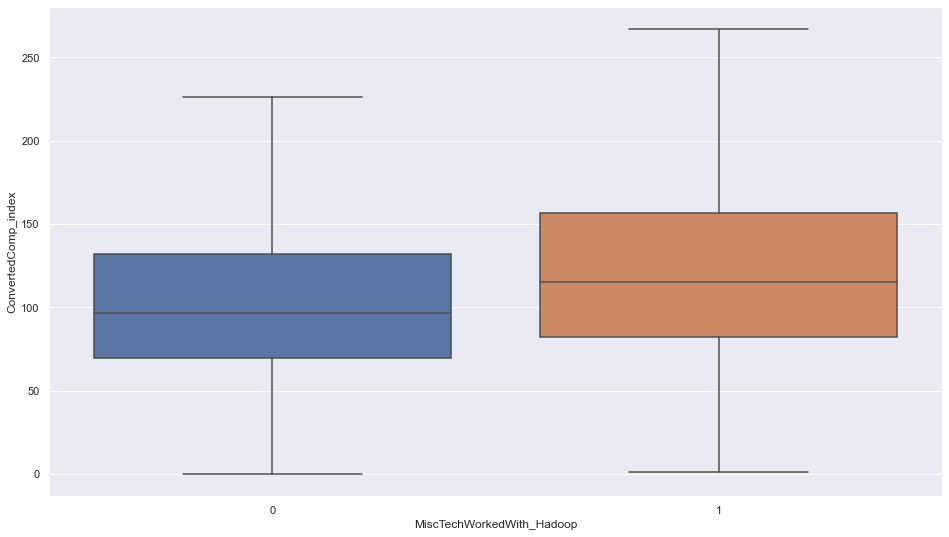

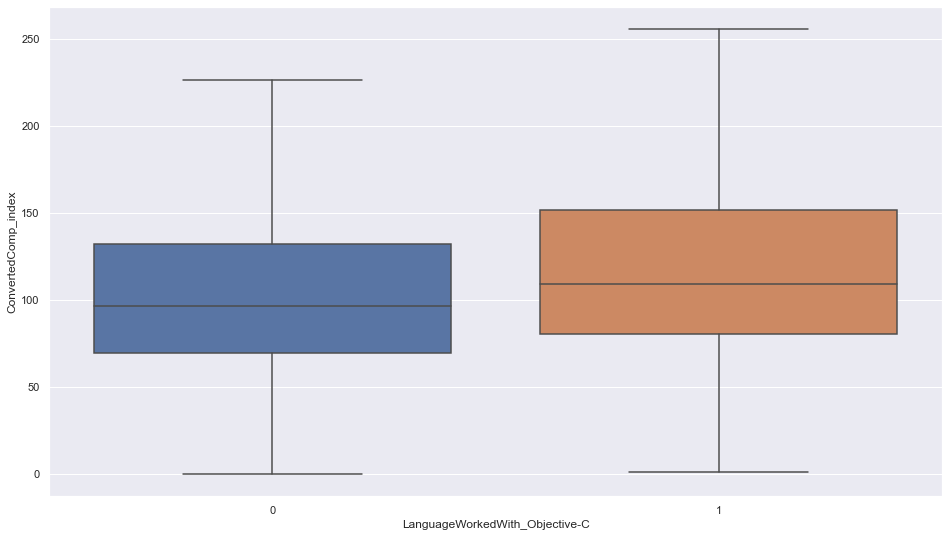

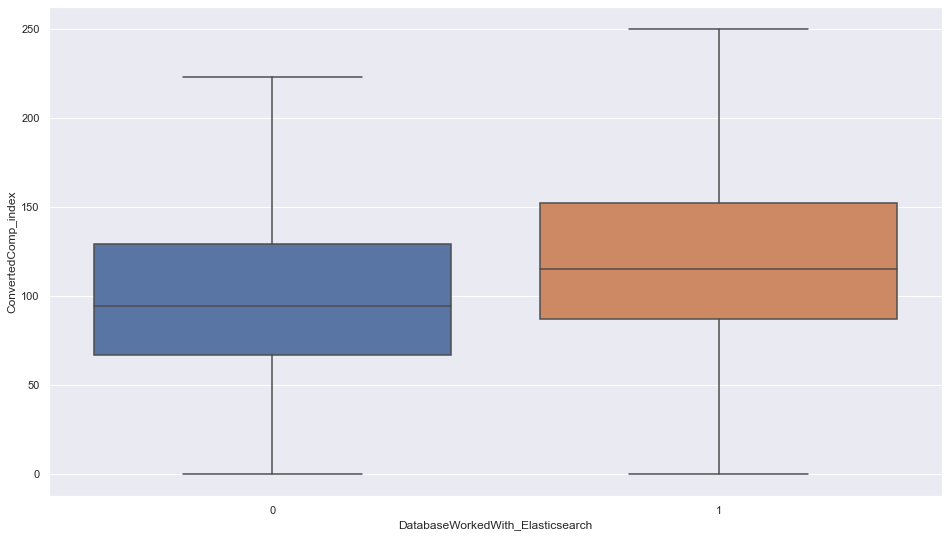

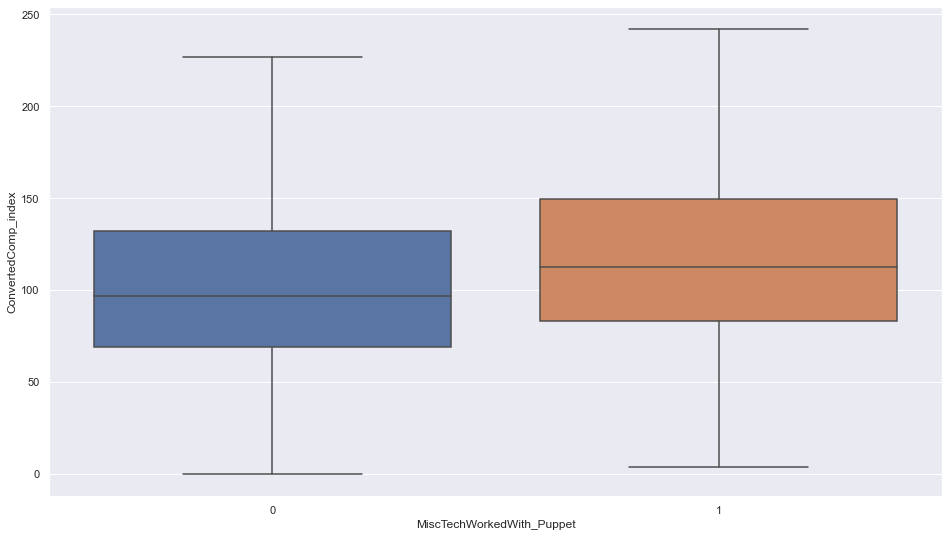

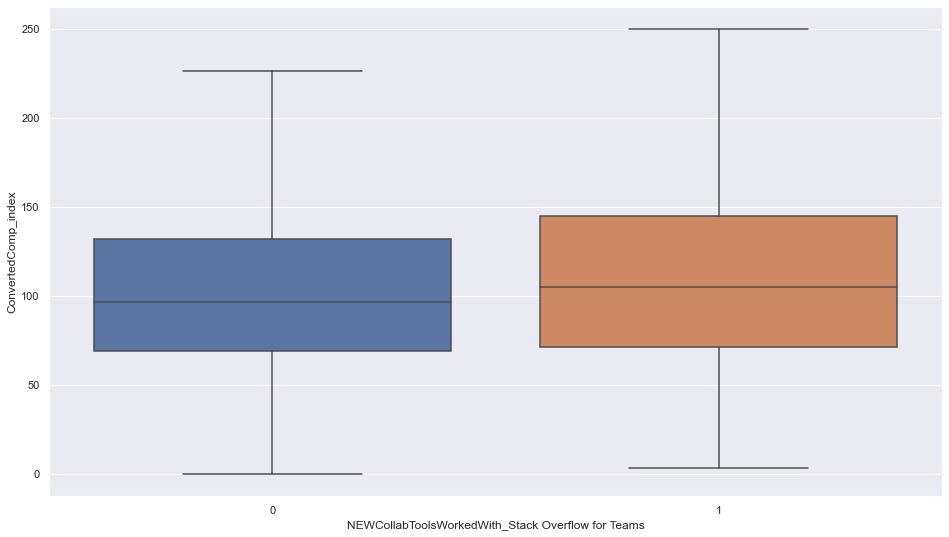

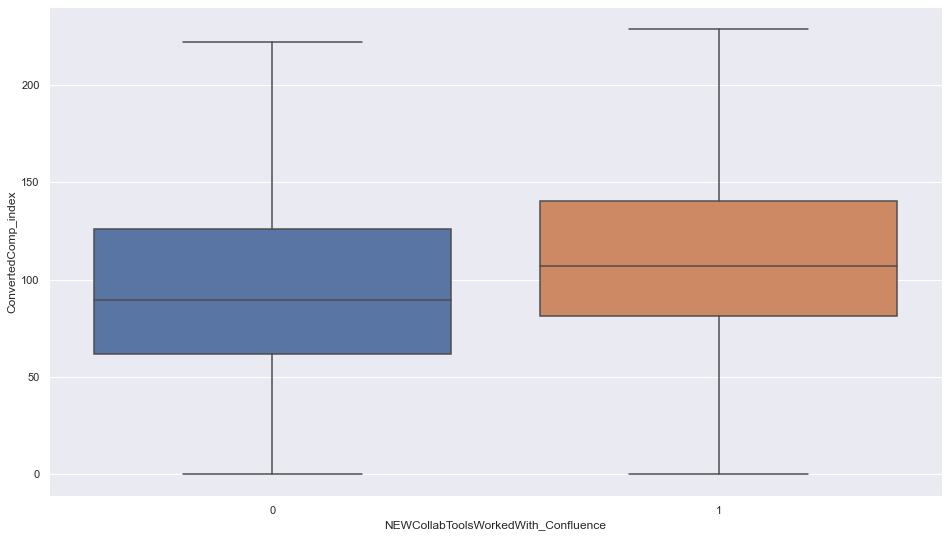

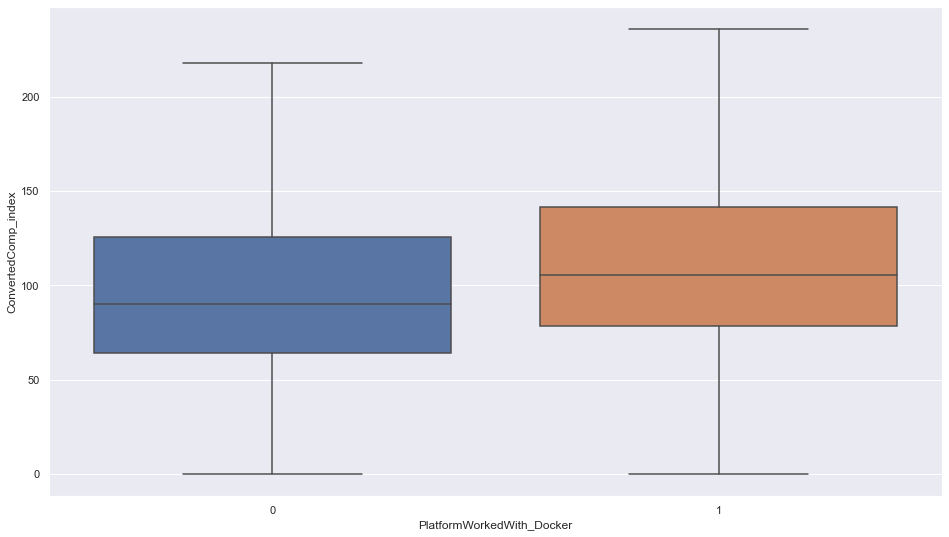

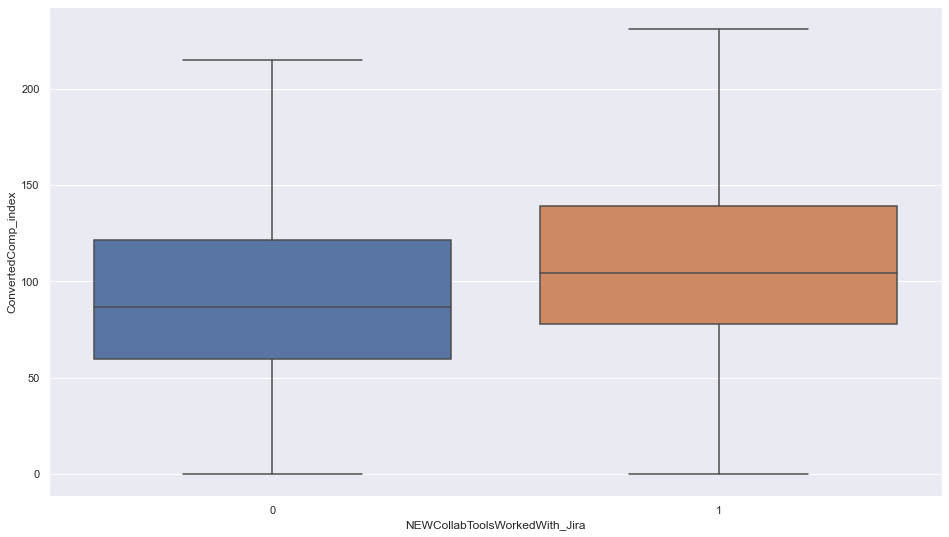

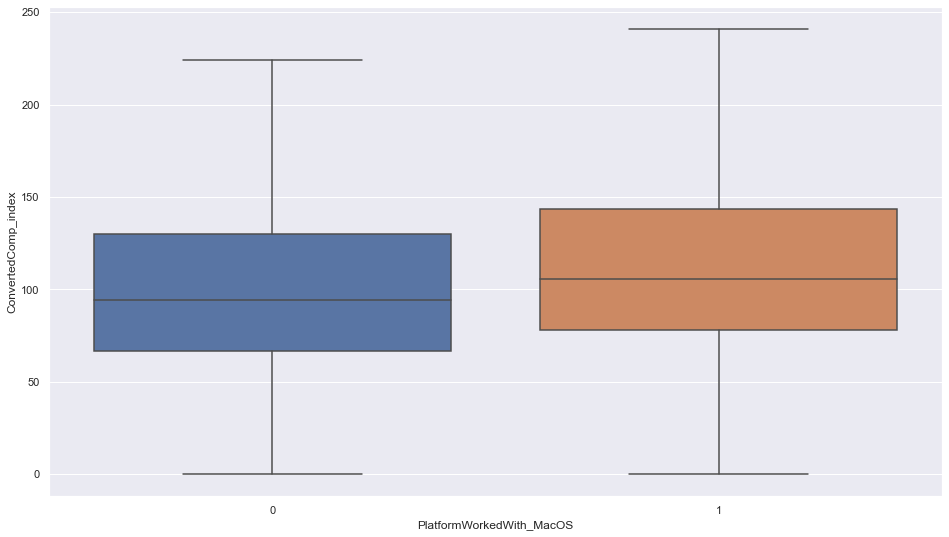

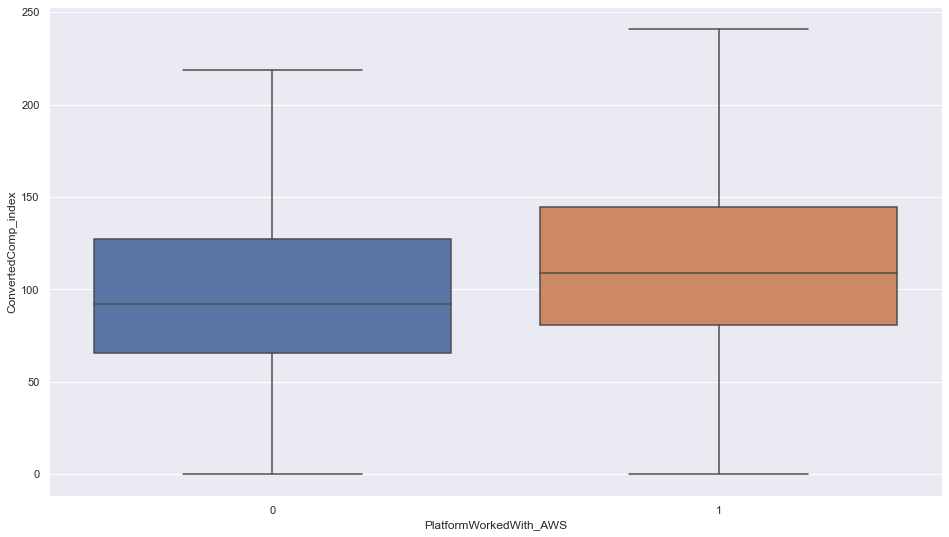

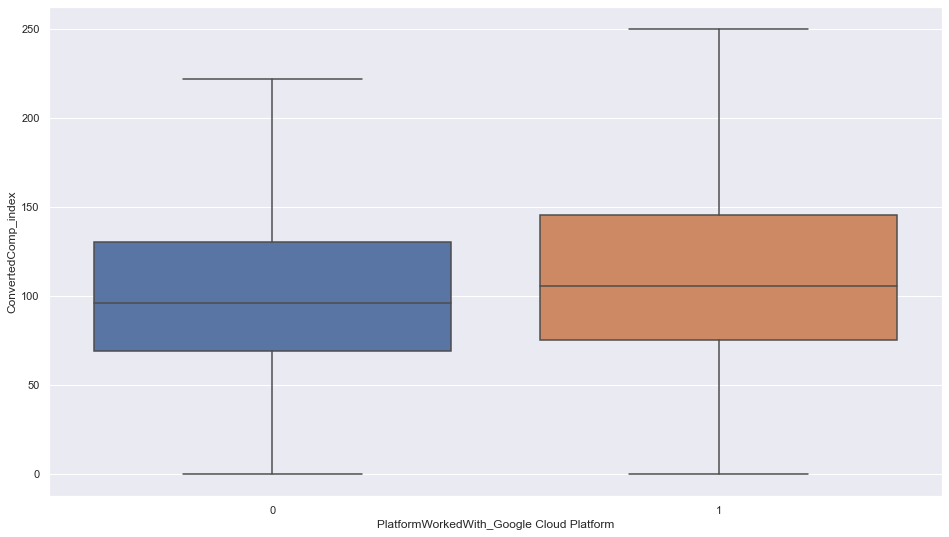

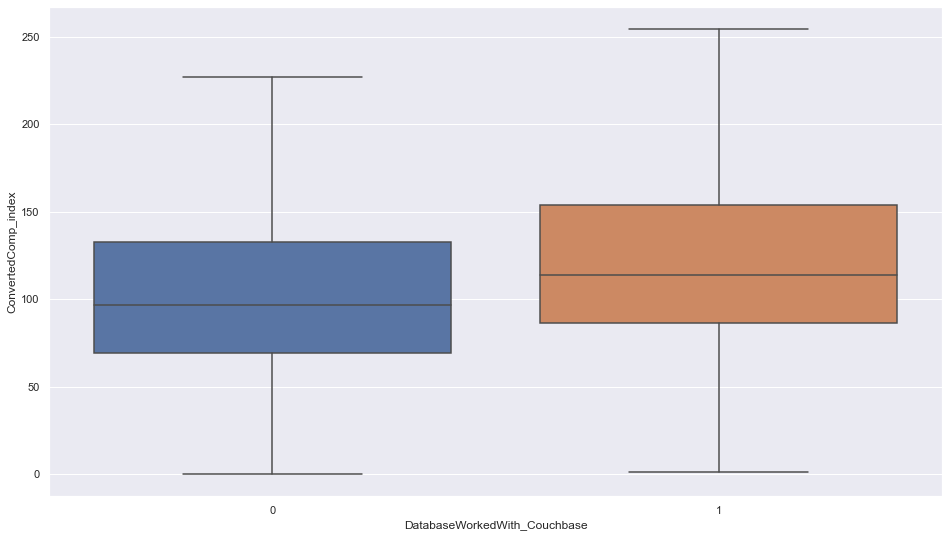

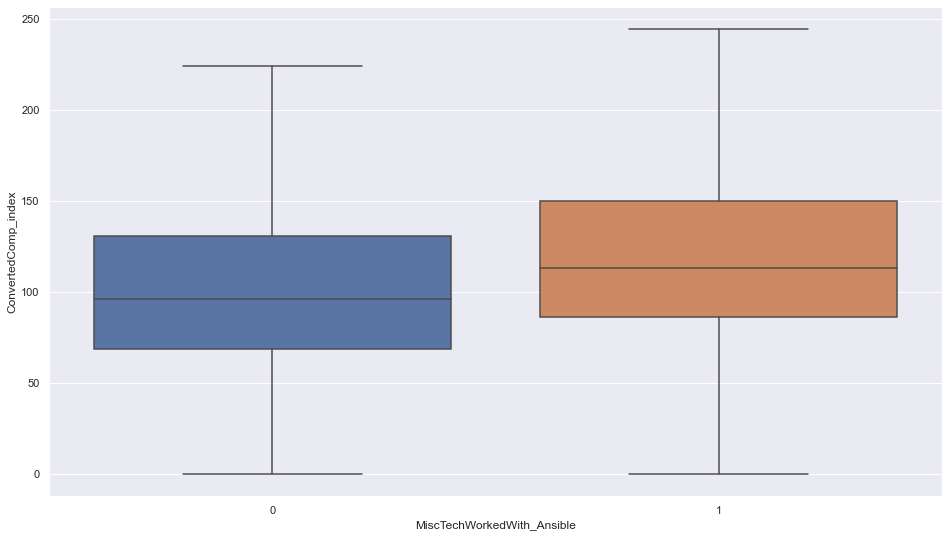

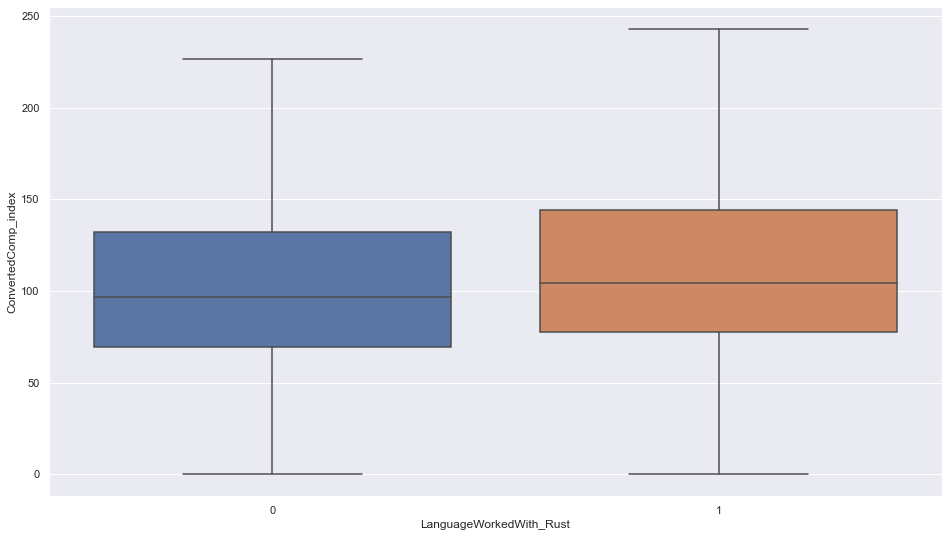

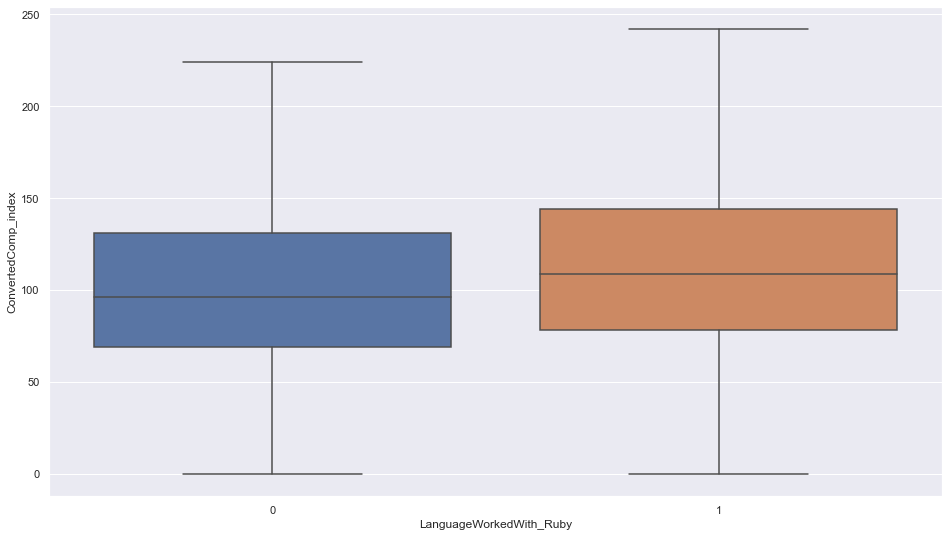

In [146]:
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

for i in range(len(high_leverage_technologies)):
    ax = sns.boxplot(x=high_leverage_technologies[i], y="ConvertedComp_index", data=data_,
                     showfliers = False)
    plt.show()

### By DevType

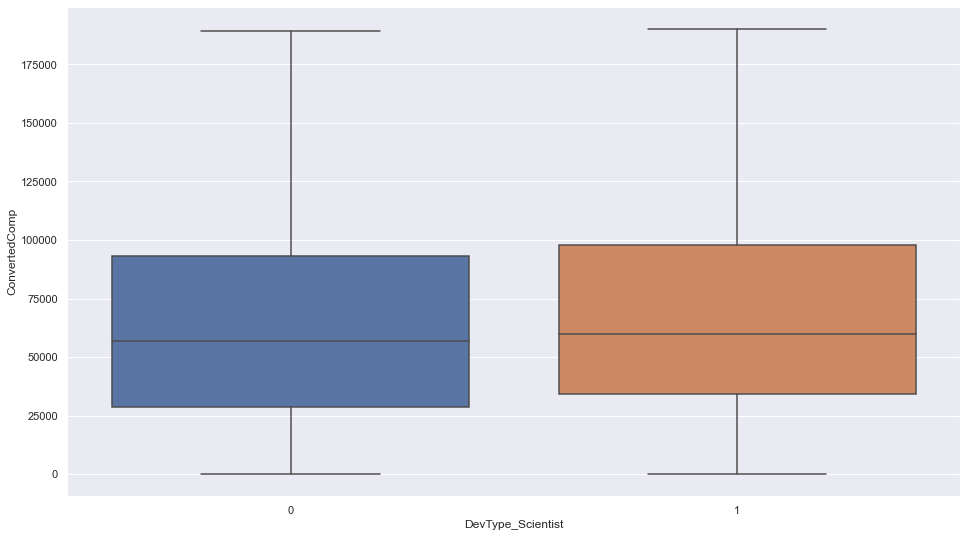

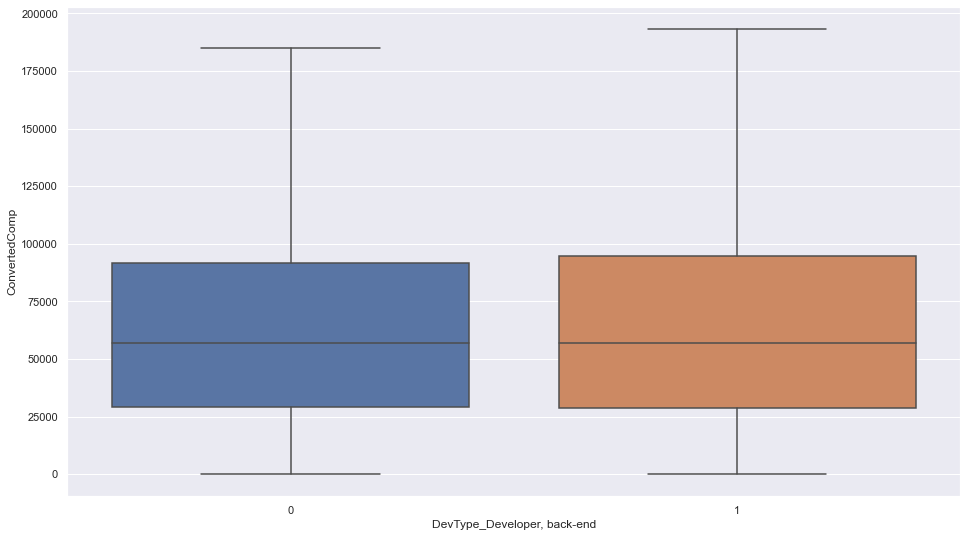

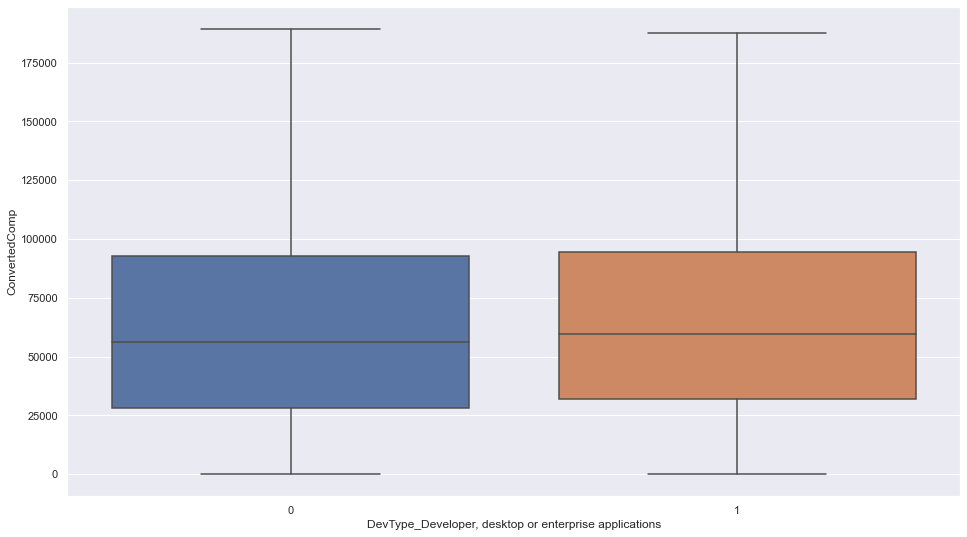

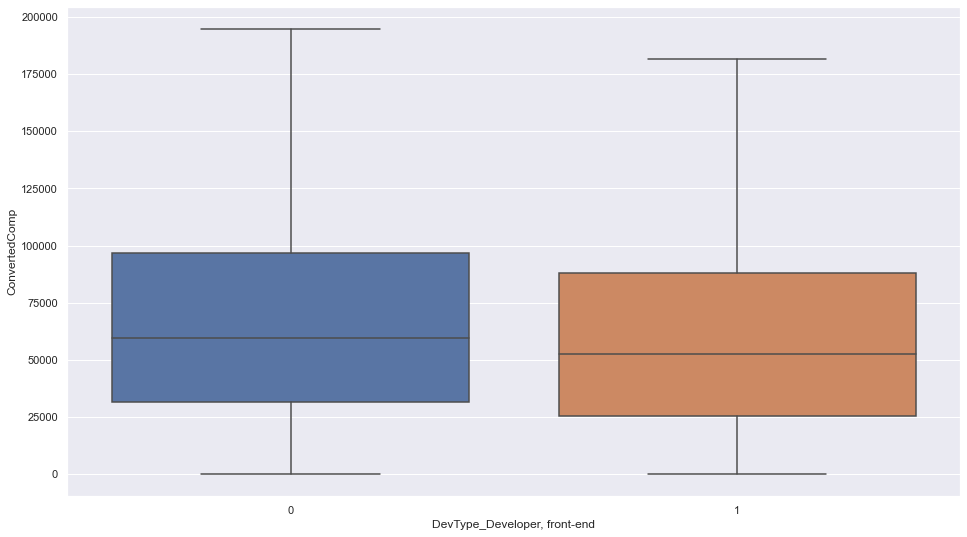

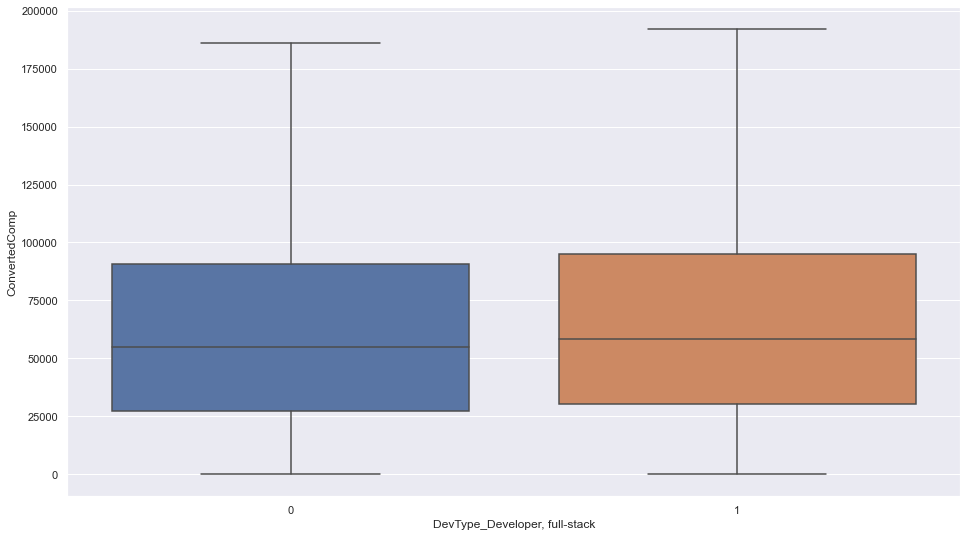

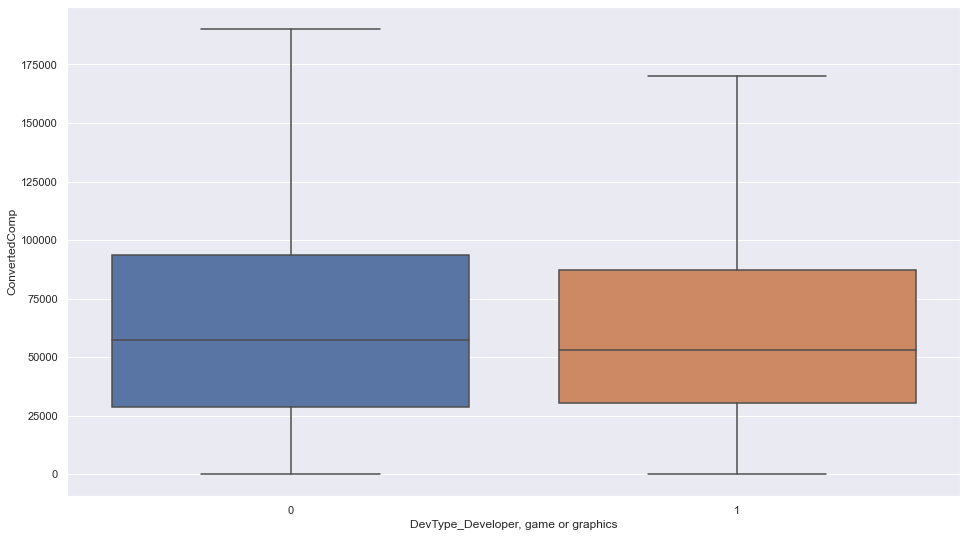

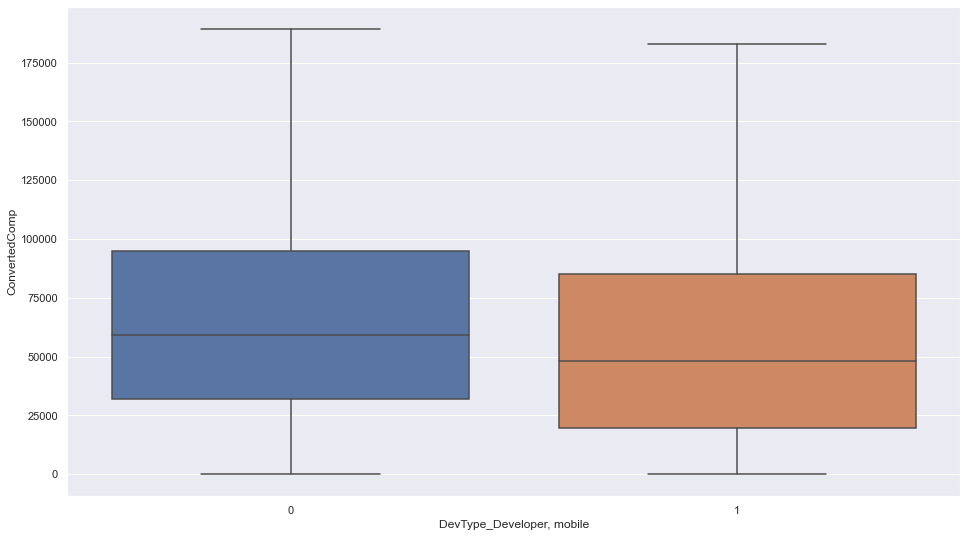

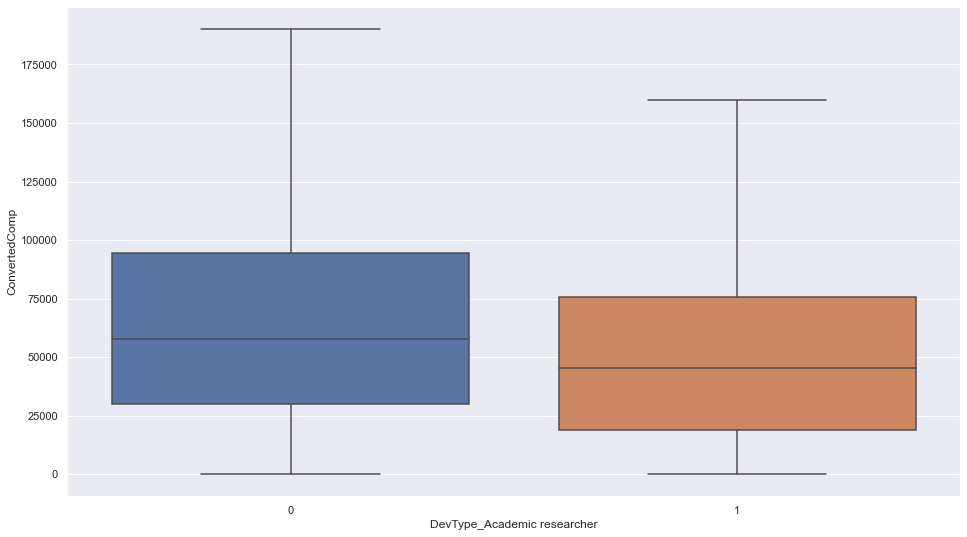

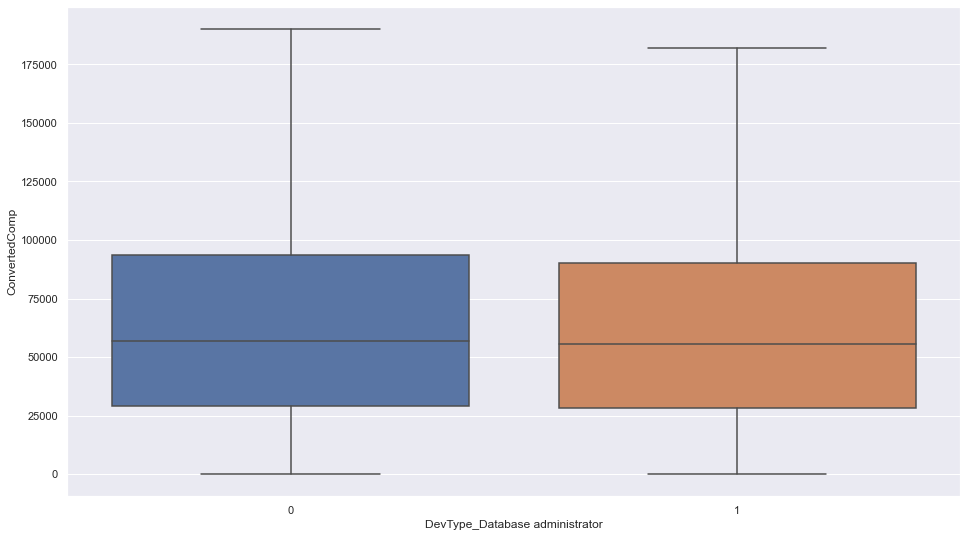

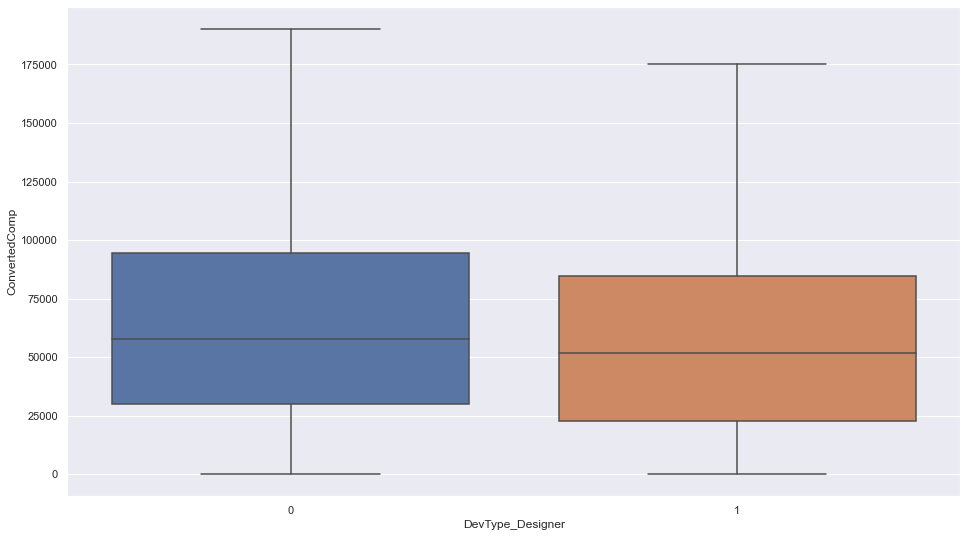

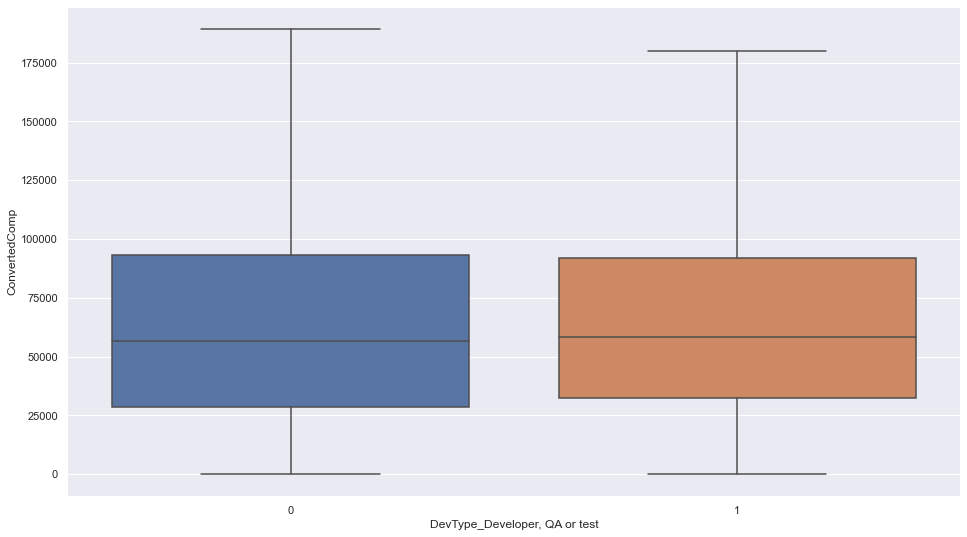

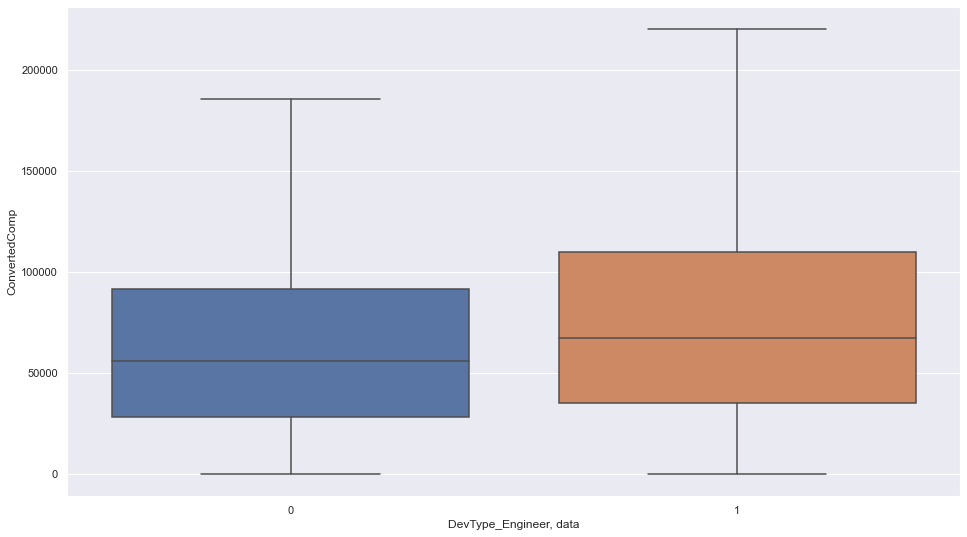

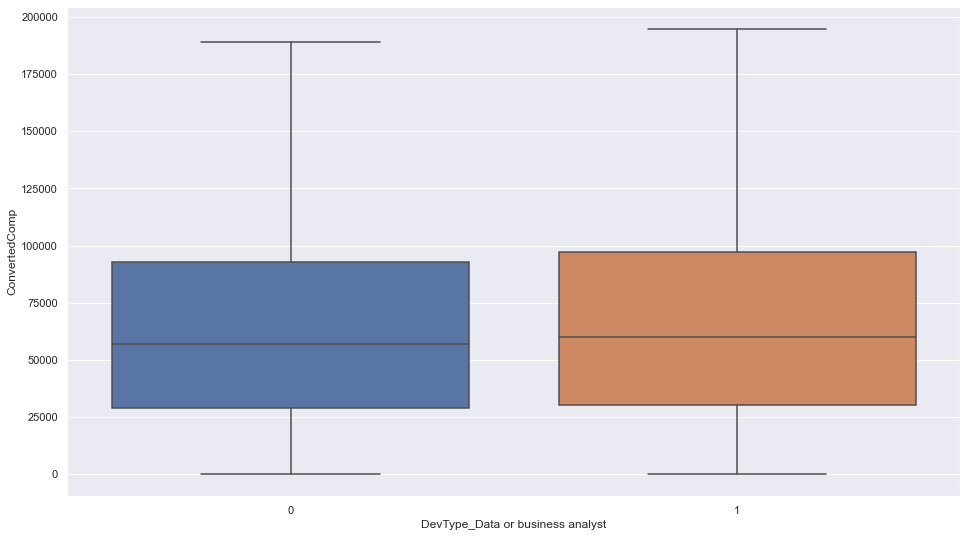

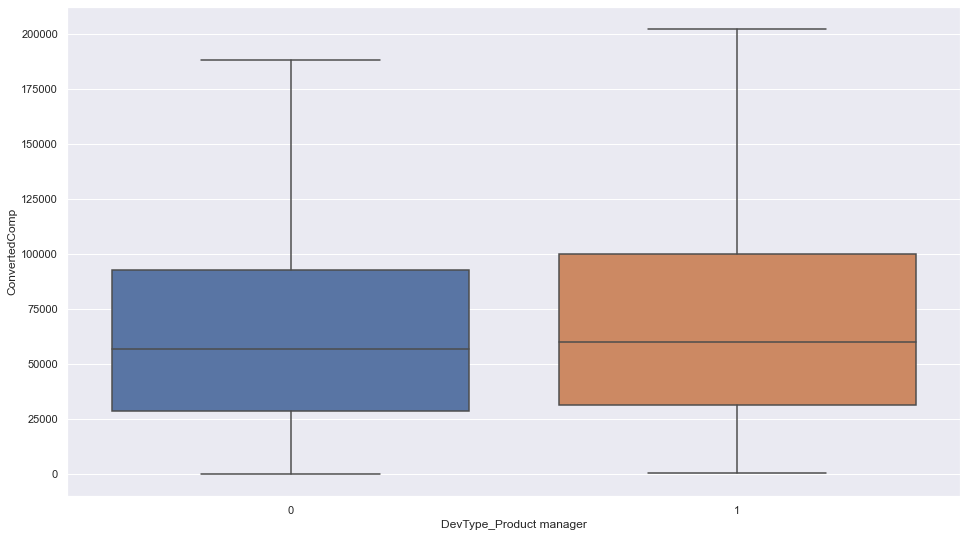

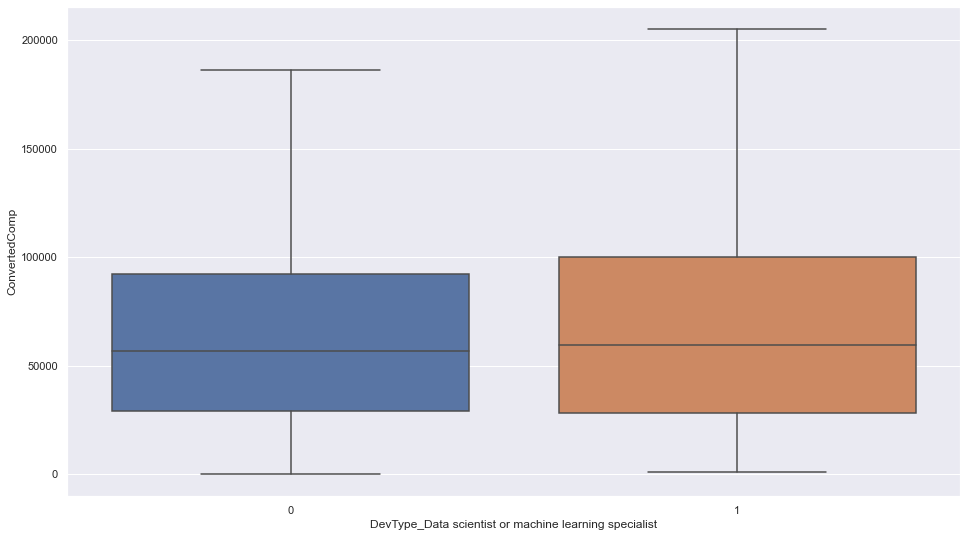

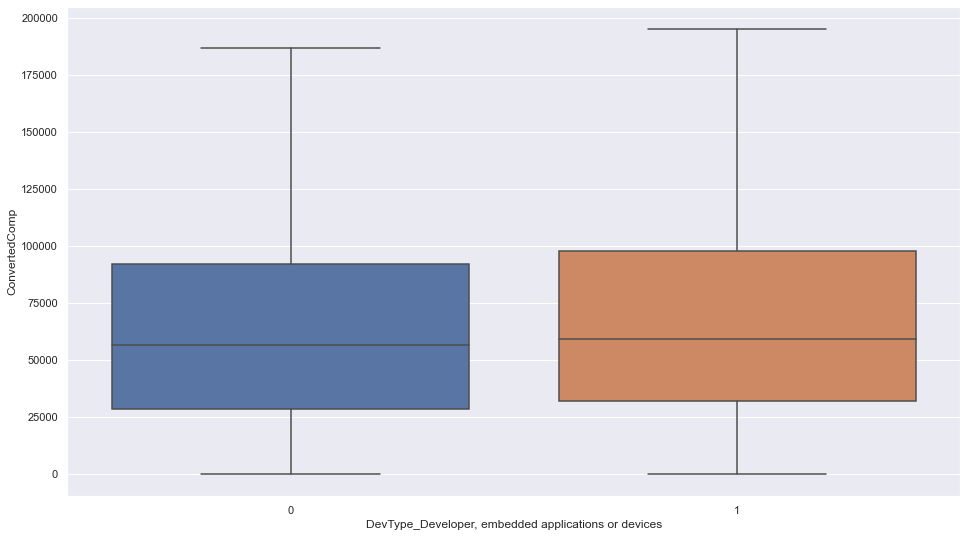

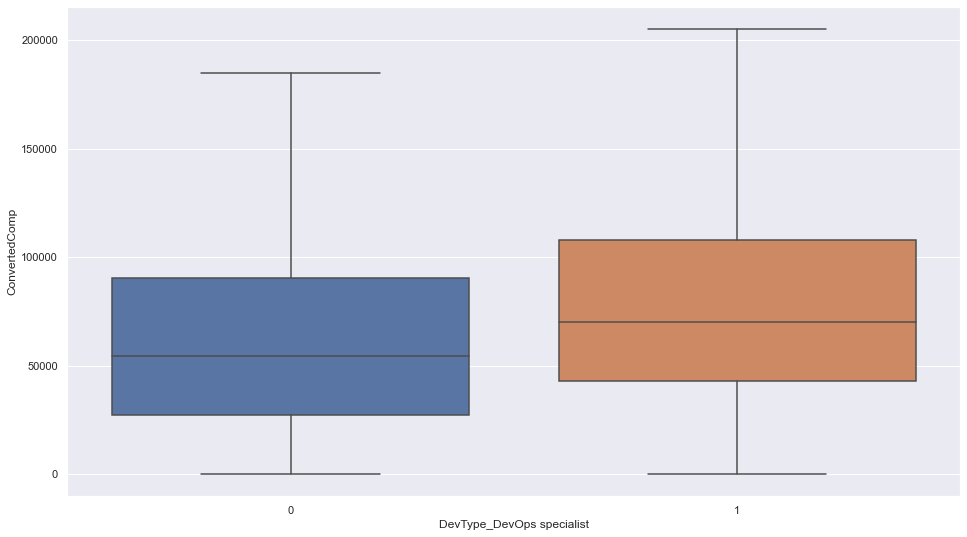

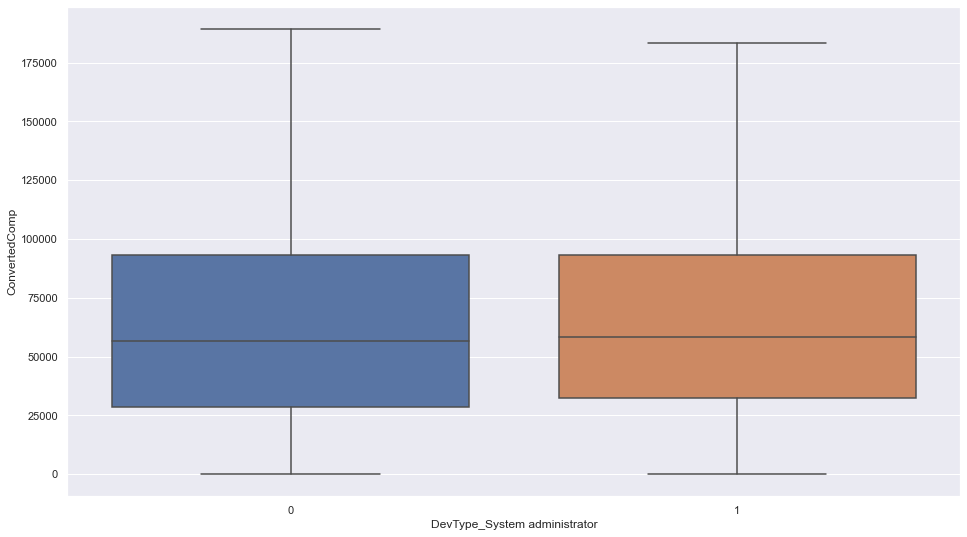

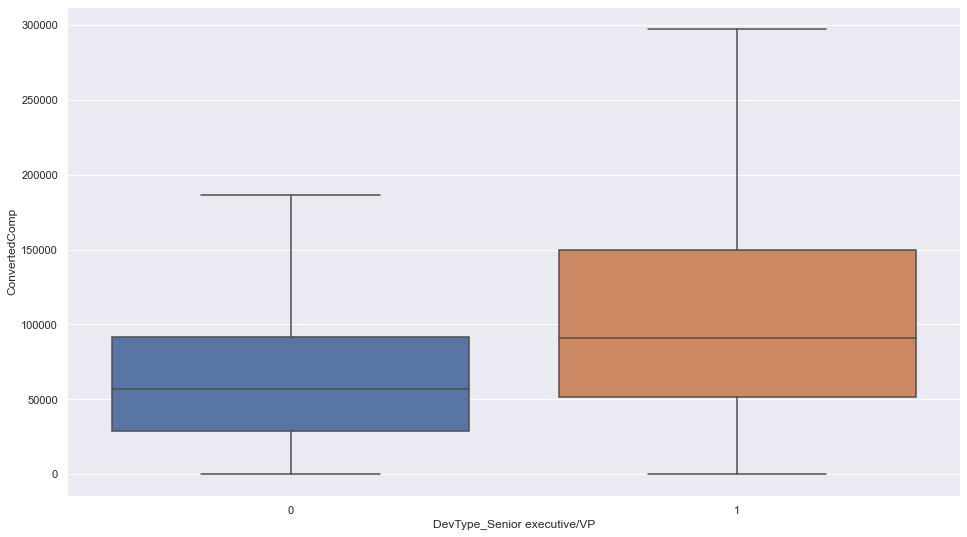

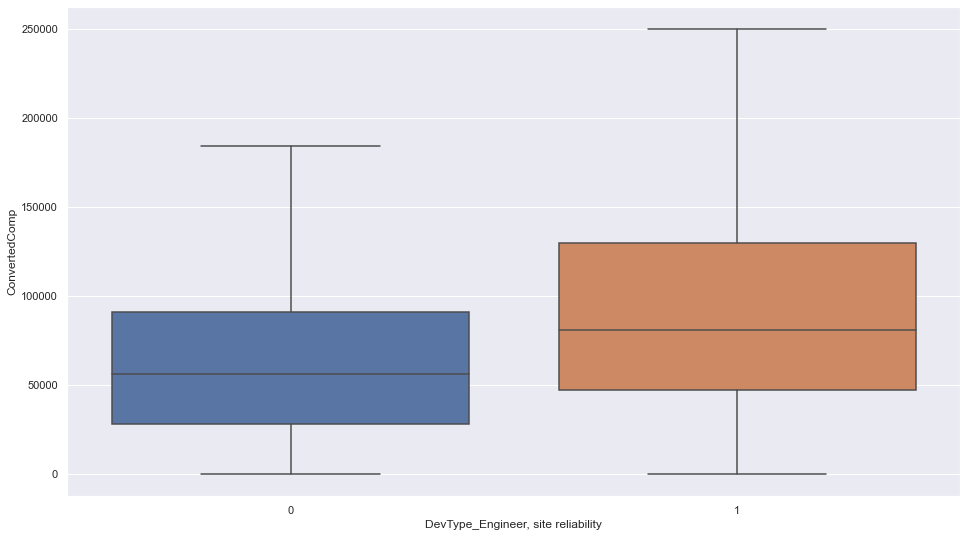

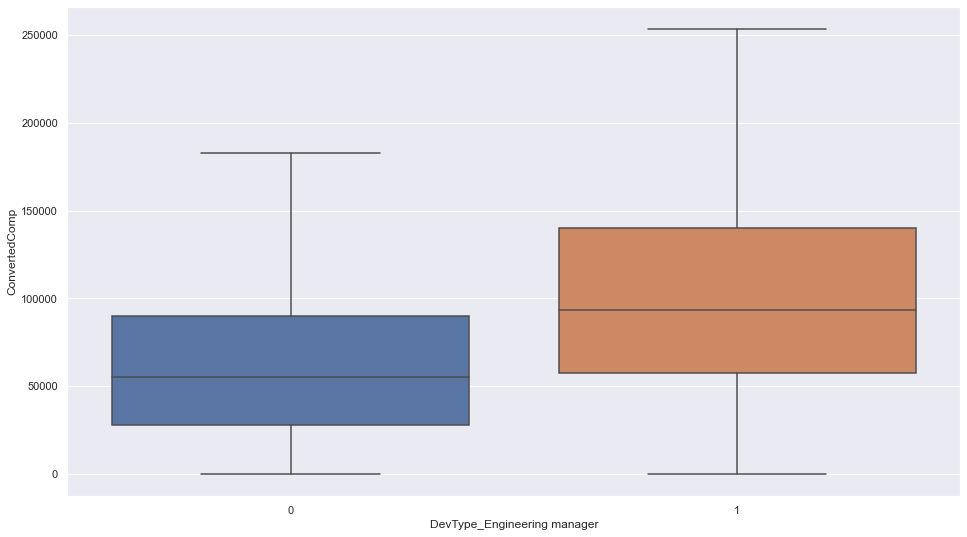

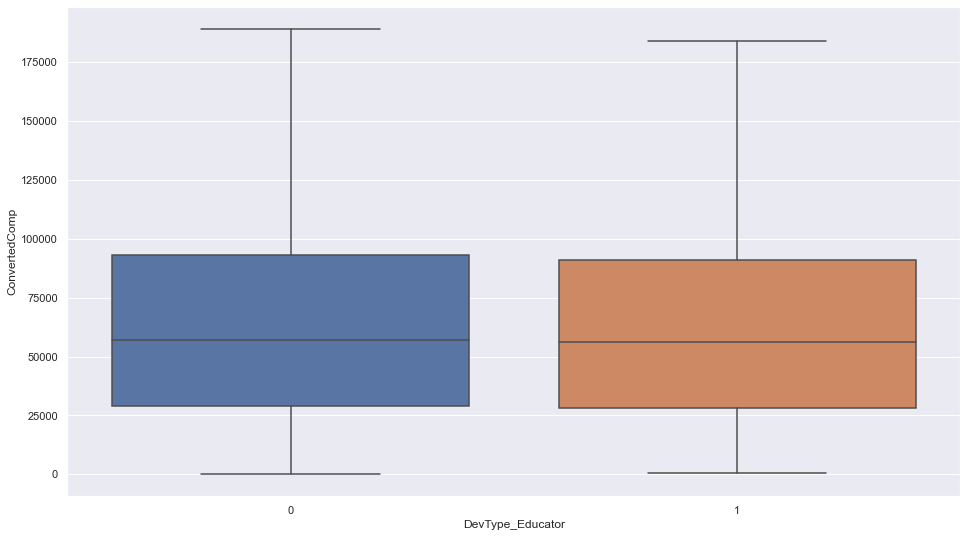

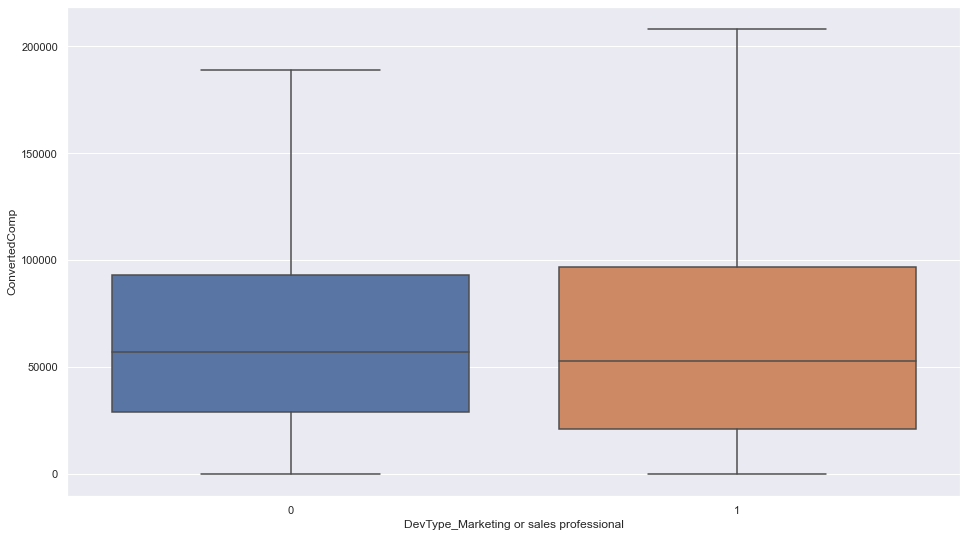

In [156]:
dev_type = [col for col in data.columns if "DevType_" in col]
data_ =  data[(data.MainBranch == "I am a developer by profession")
             &  (data.ConvertedComp <= 300000)]

for col in dev_type:
    ax = sns.boxplot(x=col, y="ConvertedComp", data=data_,
                     showfliers = False)
    plt.show()